In [ ]:
! pip install tensorflow
! pip install matplotlib
! pip install seaborn
! pip install scikit-learn

In [180]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os

In [181]:
# Download the 'horses_or_humans' dataset from TensorFlow datasets
dataset, info = tfds.load('horses_or_humans', with_info=True, as_supervised=True)

In [193]:
# Step 1: Load and preprocess the dataset
train_data = dataset['train']
test_data = dataset['test']

IMG_SIZE = (224, 224)  # ResNet50 expects 224x224 input size
BATCH_SIZE = 32

In [194]:
#Step 2: View the number of training and testing images
num_train_images = sum(1 for _ in train_data)
num_test_images = sum(1 for _ in test_data)

print(f'Number of training images: {num_train_images}')
print(f'Number of testing images: {num_test_images}')

Number of training images: 1027
Number of testing images: 256


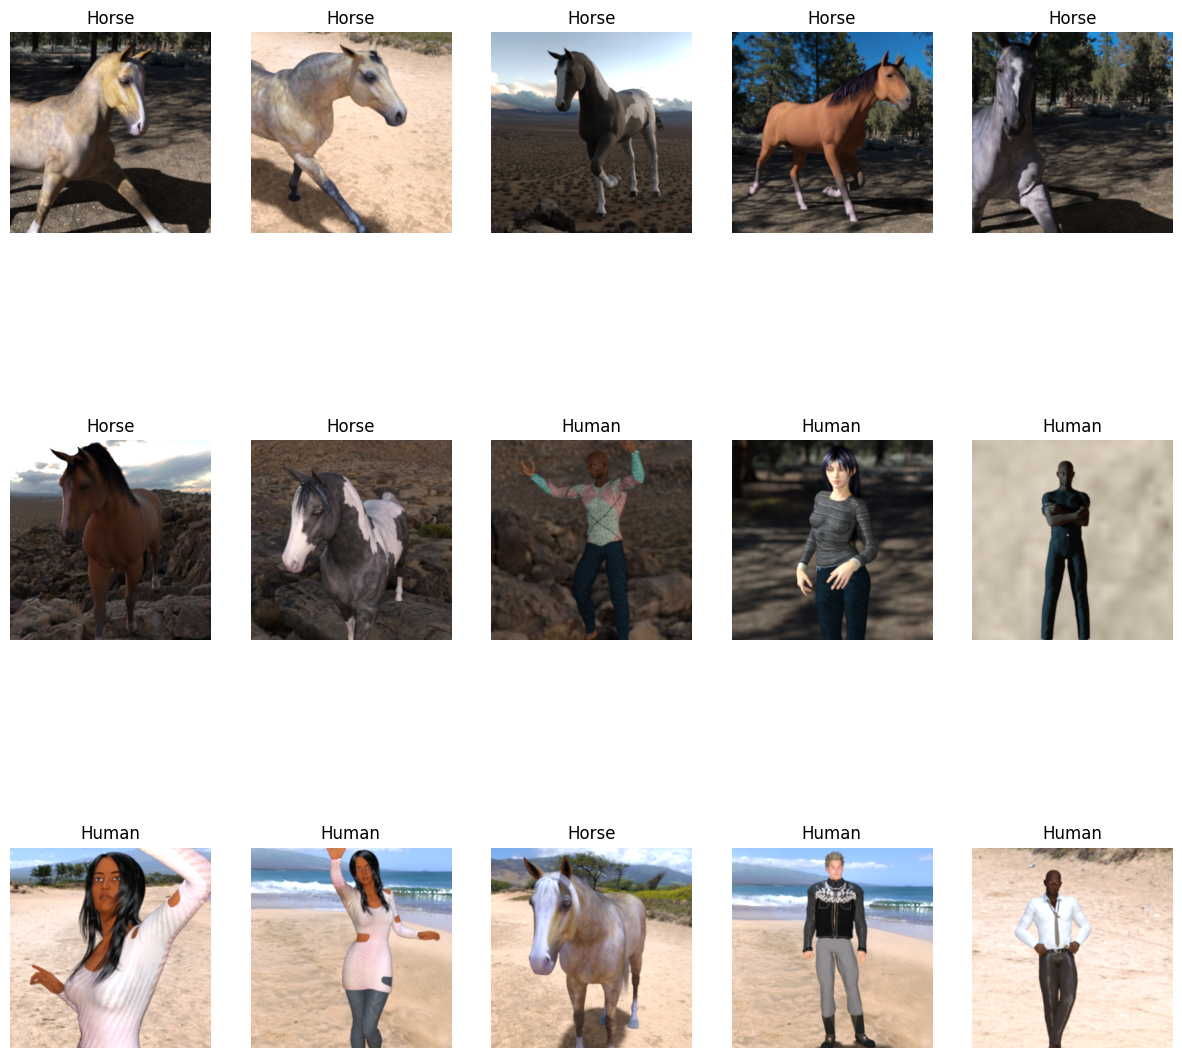

In [195]:
# Step 3: Plot some images from the dataset
def plot_images(dataset, num_images=15):
    plt.figure(figsize=(15, 15))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(3, 5, i+1)
        plt.imshow(image)
        plt.title('Horse' if label == 0 else 'Human')
        plt.axis('off')
    plt.show()

plot_images(train_data)

In [196]:
# Step 4: Build the model with ResNet50 (pre-trained)
def build_pretrained_model(base_model, learning_rate=0.001):
    # Freeze the layers of the pre-trained model
    base_model.trainable = False

    # Add custom classification head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),  # Add dropout to prevent overfitting
        Dense(1, activation='sigmoid')  # Binary classification (Horse vs Human)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [197]:
# Initialize ResNet50 base model with pre-trained weights
resnet_base = ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')


In [198]:
# Build the final model
resnet_model = build_pretrained_model(resnet_base, learning_rate=0.001)

In [199]:
# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [200]:
# Step 6: Train the model and display the accuracy
# Resize images to 150x150 for ResNet input requirements
train_data_resized = train_data.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
test_data_resized = test_data.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))

In [201]:
# Apply data augmentation (rotation, flip, zoom)
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

train_data_resized = train_data_resized.map(augment_data)

In [202]:
# Batch and prefetch the data for efficient processing
train_data_resized = train_data_resized.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_data_resized = test_data_resized.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [203]:
# Step 6: Train the ResNet model and display the accuracy
history_resnet = resnet_model.fit(
    train_data_resized,
    validation_data=test_data_resized,
    epochs=5,  # Increase epochs for more training
    callbacks=[early_stop]
)

Epoch 1/5
33/33 [==============================] - 74s 2s/step - loss: 0.3325 - accuracy: 0.8539 - val_loss: 0.0828 - val_accuracy: 0.9961
Epoch 2/5
33/33 [==============================] - 74s 2s/step - loss: 0.0587 - accuracy: 0.9834 - val_loss: 0.0501 - val_accuracy: 0.9961
Epoch 3/5
33/33 [==============================] - 79s 2s/step - loss: 0.0303 - accuracy: 0.9932 - val_loss: 0.0525 - val_accuracy: 0.9805
Epoch 4/5
33/33 [==============================] - 76s 2s/step - loss: 0.0249 - accuracy: 0.9932 - val_loss: 0.0496 - val_accuracy: 0.9883
Epoch 5/5
33/33 [==============================] - 75s 2s/step - loss: 0.0210 - accuracy: 0.9942 - val_loss: 0.0437 - val_accuracy: 0.9922


In [207]:
# Show training and testing accuracy
train_accuracy = history_resnet.history['accuracy']
test_accuracy = history_resnet.history['val_accuracy']

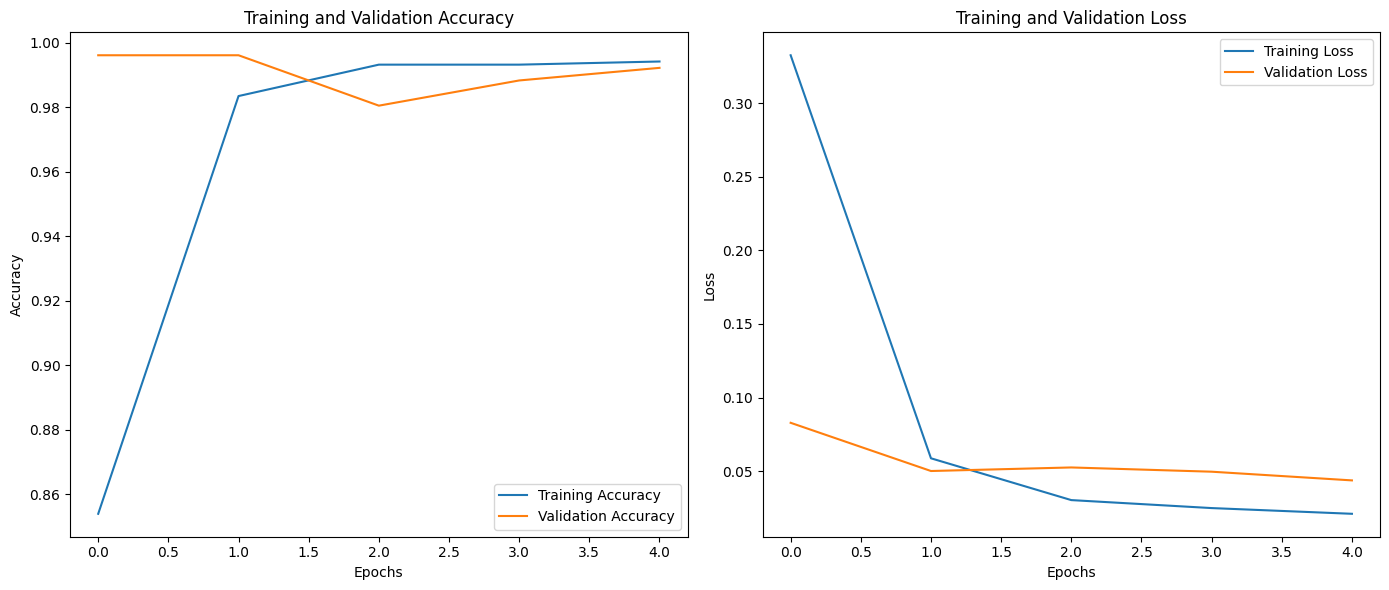

In [208]:
# Plot the training and validation accuracy
# Step 7: Plot training and validation accuracy and loss in subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot accuracy
ax[0].plot(history_resnet.history['accuracy'], label='Training Accuracy')
ax[0].plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot loss
ax[1].plot(history_resnet.history['loss'], label='Training Loss')
ax[1].plot(history_resnet.history['val_loss'], label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()

# Show the plots
plt.show()


In [209]:
# Print final accuracy values
print(f"Final Training Accuracy: {train_accuracy[-1]*100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy[-1]*100:.2f}%")

Final Training Accuracy: 99.42%
Final Test Accuracy: 99.22%
